<a href="https://colab.research.google.com/github/sunweihao1997/swh_code/blob/master/XGBoost_typhoon_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌀 台风频数季节性预测模型
## 基于XGBoost与ENSO修正的统计-动力相结合方案

---

### 使用说明
1. 按顺序运行每个代码单元格
2. 在"配置参数"部分修改您的文件路径和变量名
3. 上传数据文件后运行模型训练
4. 查看结果并进行预测

In [1]:
# 安装必要的库
!pip install xgboost -q

# 导入所需库
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import pickle
import json

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

print("✅ 环境配置完成！")
print(f"   XGBoost版本: {xgb.__version__}")

✅ 环境配置完成！
   XGBoost版本: 3.1.2


## 2️⃣ 上传数据文件

In [2]:
from google.colab import files

print("请上传以下文件:")
print("  1. typhoon_count.csv (台风数据)")
print("  2. MEI的NC文件")
print("  3. PDO的NC文件")
print("  4. IOD的NC文件")
print("  5. QBO的NC文件")
print("\n点击下方'选择文件'按钮上传...")

uploaded = files.upload()

print(f"\n✅ 已上传 {len(uploaded)} 个文件:")
for fname in uploaded.keys():
    print(f"   - {fname}")

请上传以下文件:
  1. typhoon_count.csv (台风数据)
  2. MEI的NC文件
  3. PDO的NC文件
  4. IOD的NC文件
  5. QBO的NC文件

点击下方'选择文件'按钮上传...


Saving iod_ersst_v5.nc to iod_ersst_v5 (1).nc
Saving mei_v2.nc to mei_v2 (1).nc
Saving pdo_ersst_v5.nc to pdo_ersst_v5 (1).nc
Saving qbo.nc to qbo (1).nc
Saving typhoon_count.csv to typhoon_count (2).csv

✅ 已上传 5 个文件:
   - iod_ersst_v5 (1).nc
   - mei_v2 (1).nc
   - pdo_ersst_v5 (1).nc
   - qbo (1).nc
   - typhoon_count (2).csv


## 3️⃣ 检查NC文件结构

运行此单元格查看您的NC文件包含哪些变量，以便正确配置。

In [3]:
# 列出当前目录的文件
print("当前目录文件:")
for f in os.listdir('.'):
    if f.endswith('.nc') or f.endswith('.csv'):
        print(f"  {f}")

print("\n" + "="*50)

# 检查每个NC文件的结构
nc_files = [f for f in os.listdir('.') if f.endswith('.nc')]

for nc_file in nc_files:
    print(f"\n📄 {nc_file}:")
    try:
        ds = xr.open_dataset(nc_file)
        print(f"   维度: {dict(ds.dims)}")
        print(f"   数据变量: {list(ds.data_vars)}")
        print(f"   坐标: {list(ds.coords)}")

        # 显示时间范围
        if 'time' in ds.coords:
            time_range = pd.to_datetime(ds['time'].values)
            print(f"   时间范围: {time_range.min().year} - {time_range.max().year}")
        ds.close()
    except Exception as e:
        print(f"   ❌ 读取失败: {e}")

当前目录文件:
  typhoon_count (2).csv
  iod_ersst_v5.nc
  pdo_ersst_v5 (1).nc
  typhoon_count.csv
  pdo_ersst_v5.nc
  typhoon_count (1).csv
  qbo (1).nc
  mei_v2.nc
  qbo.nc
  mei_v2 (1).nc
  iod_ersst_v5 (1).nc


📄 iod_ersst_v5.nc:
   维度: {'time': 2063}
   数据变量: ['iod']
   坐标: ['time']
   时间范围: 1854 - 2025

📄 pdo_ersst_v5 (1).nc:
   维度: {'time': 2064}
   数据变量: ['pdo']
   坐标: ['time']
   时间范围: 1854 - 2025

📄 pdo_ersst_v5.nc:
   维度: {'time': 2064}
   数据变量: ['pdo']
   坐标: ['time']
   时间范围: 1854 - 2025

📄 qbo (1).nc:
   维度: {'time': 935}
   数据变量: ['value']
   坐标: ['time']
   时间范围: 1948 - 2025

📄 mei_v2.nc:
   维度: {'time': 564}
   数据变量: ['mei']
   坐标: ['time']
   时间范围: 1979 - 2025

📄 qbo.nc:
   维度: {'time': 935}
   数据变量: ['value']
   坐标: ['time']
   时间范围: 1948 - 2025

📄 mei_v2 (1).nc:
   维度: {'time': 564}
   数据变量: ['mei']
   坐标: ['time']
   时间范围: 1979 - 2025

📄 iod_ersst_v5 (1).nc:
   维度: {'time': 2063}
   数据变量: ['iod']
   坐标: ['time']
   时间范围: 1854 - 2025


## 4️⃣ 配置参数 ⚠️ 请根据上一步的输出修改此单元格

In [10]:
# ============================================================
# ⚠️ 重要：请根据您的实际文件修改以下配置
# ============================================================

class Config:
    """
    配置类 - 请根据您的实际数据文件修改
    """

    # ----- 数据文件路径 -----
    # 请替换为您实际的文件名
    TYPHOON_DATA_PATH = 'typhoon_count.csv'
    MEI_NC_PATH = 'mei_v2.nc'      # ← 修改为您的MEI文件名
    PDO_NC_PATH = 'pdo_ersst_v5.nc'      # ← 修改为您的PDO文件名
    IOD_NC_PATH = 'iod_ersst_v5.nc'      # ← 修改为您的IOD文件名
    QBO_NC_PATH = 'qbo.nc'      # ← 修改为您的QBO文件名

    # ----- NC文件变量名 -----
    # ⚠️ 请根据上一步检查结果修改
    MEI_VAR_NAME = 'mei'        # ← 修改为您NC文件中MEI的变量名
    PDO_VAR_NAME = 'pdo'        # ← 修改为您NC文件中PDO的变量名
    IOD_VAR_NAME = 'iod'        # ← 修改为您NC文件中IOD的变量名
    QBO_VAR_NAME = 'value'        # ← 修改为您NC文件中QBO的变量名
    TIME_VAR_NAME = 'time'      # 时间维度名（通常不需要修改）

    # ----- 模型参数 -----
    START_YEAR = 1980           # 训练数据起始年
    END_YEAR = 2024             # 训练数据结束年
    PREDICT_YEAR = 2025         # 预测目标年份
    TEST_SPLIT_YEAR = 2015      # 测试集起始年

    # ----- XGBoost超参数 (通常不需要修改) -----
    XGB_PARAMS = {
        'objective': 'count:poisson',
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'verbosity': 0
    }

    # ----- 海区列表 -----
    REGIONS = ['South China Sea', 'Eastern China Sea', 'Japan Sea', 'Yellow Sea']

    # ----- 输出配置 -----
    OUTPUT_DIR = 'model_outputs'
    SAVE_MODEL = True

print("✅ 配置已加载！")
print(f"   训练年份范围: {Config.START_YEAR} - {Config.END_YEAR}")
print(f"   测试集起始: {Config.TEST_SPLIT_YEAR}")

✅ 配置已加载！
   训练年份范围: 1980 - 2024
   测试集起始: 2015


## 5️⃣ 数据加载模块


In [11]:
class DataLoader:
    """数据加载器类"""

    def __init__(self, config):
        self.config = config
        self.typhoon_data = None
        self.climate_indices = None

    def load_typhoon_data(self):
        """加载台风频数数据"""
        print("\n[1/5] 加载台风数据...")
        df = pd.read_csv(self.config.TYPHOON_DATA_PATH)
        print(f"    ✓ 成功加载: {len(df)} 条记录")
        print(f"    ✓ 时间范围: {df['Year'].min()} - {df['Year'].max()}")
        print(f"    ✓ 海区: {df['Region'].unique().tolist()}")
        self.typhoon_data = df
        return df

    def load_climate_index_from_nc(self, nc_path, var_name, index_name):
        """从NC文件加载气候指数"""
        try:
            ds = xr.open_dataset(nc_path)

            if var_name in ds.data_vars:
                data = ds[var_name]
            else:
                available_vars = list(ds.data_vars)
                print(f"    ! 警告: 未找到'{var_name}', 可用: {available_vars}")
                if len(available_vars) == 1:
                    var_name = available_vars[0]
                    data = ds[var_name]
                    print(f"    ! 自动使用: {var_name}")
                else:
                    raise ValueError(f"请指定正确的变量名")

            df = data.to_dataframe().reset_index()

            time_col = self.config.TIME_VAR_NAME
            if time_col not in df.columns:
                for col in df.columns:
                    if 'time' in col.lower():
                        time_col = col
                        break

            df['year'] = pd.to_datetime(df[time_col]).dt.year
            df['month'] = pd.to_datetime(df[time_col]).dt.month
            df['value'] = df[var_name]

            result = df[['year', 'month', 'value']].copy()
            ds.close()
            return result

        except Exception as e:
            print(f"    ! 加载{index_name}失败: {e}")
            return None

    def load_all_climate_indices(self):
        """加载所有气候指数"""
        print("\n[2/5] 加载气候指数...")
        indices = {}

        for name, path, var in [
            ('MEI', self.config.MEI_NC_PATH, self.config.MEI_VAR_NAME),
            ('PDO', self.config.PDO_NC_PATH, self.config.PDO_VAR_NAME),
            ('IOD', self.config.IOD_NC_PATH, self.config.IOD_VAR_NAME),
            ('QBO', self.config.QBO_NC_PATH, self.config.QBO_VAR_NAME)
        ]:
            print(f"    加载{name}...")
            data = self.load_climate_index_from_nc(path, var, name)
            if data is not None:
                indices[name] = data
                print(f"    ✓ {name}: {data['year'].min()}-{data['year'].max()}")

        self.climate_indices = indices
        return indices

    def calculate_ond_average(self, index_data, year):
        """计算OND平均值"""
        mask = (index_data['year'] == year) & (index_data['month'].isin([10, 11, 12]))
        values = index_data.loc[mask, 'value']
        return values.mean() if len(values) >= 2 else np.nan

    def calculate_jaso_average(self, index_data, year):
        """计算JASO平均值"""
        mask = (index_data['year'] == year) & (index_data['month'].isin([7, 8, 9, 10]))
        values = index_data.loc[mask, 'value']
        return values.mean() if len(values) >= 2 else np.nan

    def build_feature_matrix(self):
        """构建特征矩阵"""
        print("\n[3/5] 构建特征矩阵...")

        years = sorted(self.typhoon_data['Year'].unique())
        years = [y for y in years if self.config.START_YEAR <= y <= self.config.END_YEAR]

        feature_records = []
        for year in years:
            record = {'Year': year}
            prev_year = year - 1

            for index_name, index_data in self.climate_indices.items():
                record[f'{index_name}_OND'] = self.calculate_ond_average(index_data, prev_year)

            if 'MEI' in self.climate_indices:
                record['MEI_Current_JASO'] = self.calculate_jaso_average(self.climate_indices['MEI'], year)

            feature_records.append(record)

        feature_df = pd.DataFrame(feature_records)

        typhoon_pivot = self.typhoon_data.pivot_table(
            index='Year', columns='Region', values='Typhoon_Count', aggfunc='sum'
        ).reset_index()

        for col in typhoon_pivot.columns:
            if col != 'Year':
                typhoon_pivot = typhoon_pivot.rename(columns={col: f'Target_{col}'})

        result = feature_df.merge(typhoon_pivot, on='Year', how='left')
        result = result.dropna()

        print(f"    ✓ 样本数: {len(result)}")
        print(f"    ✓ 特征: {[c for c in result.columns if '_OND' in c]}")

        return result

print("✅ 数据加载模块已定义！")

✅ 数据加载模块已定义！


## 6️⃣ 模型训练模块

In [12]:
class TyphoonPredictionModel:
    """台风预测模型类"""

    def __init__(self, config):
        self.config = config
        self.models = {}
        self.scalers = {}
        self.correction_params = {}
        self.feature_importance = {}
        self.training_history = {}

    def train_single_region(self, data, region, feature_cols):
        """训练单个海区模型"""
        target_col = f'Target_{region}'
        if target_col not in data.columns:
            return None

        X = data[feature_cols].values
        y = data[target_col].values
        years = data['Year'].values

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        self.scalers[region] = scaler

        train_mask = years < self.config.TEST_SPLIT_YEAR
        test_mask = years >= self.config.TEST_SPLIT_YEAR

        X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        years_train, years_test = years[train_mask], years[test_mask]

        model = xgb.XGBRegressor(**self.config.XGB_PARAMS)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        self.models[region] = model

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # ENSO修正
        if 'MEI_Current_JASO' in data.columns:
            mei_current = data.loc[train_mask, 'MEI_Current_JASO'].values
            residuals = y_train - y_train_pred
            valid_mask = ~np.isnan(mei_current)
            if valid_mask.sum() > 5:
                slope, intercept = np.polyfit(mei_current[valid_mask], residuals[valid_mask], 1)
                self.correction_params[region] = {'slope': slope, 'intercept': intercept}

        self.feature_importance[region] = dict(zip(feature_cols, model.feature_importances_))

        result = {
            'region': region,
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'test_r2': r2_score(y_test, y_test_pred),
            'y_train': y_train, 'y_train_pred': y_train_pred,
            'y_test': y_test, 'y_test_pred': y_test_pred,
            'years_train': years_train, 'years_test': years_test
        }
        self.training_history[region] = result
        return result

    def train_all_regions(self, data):
        """训练所有海区模型"""
        print("\n[4/5] 训练XGBoost模型...")
        feature_cols = [c for c in data.columns if '_OND' in c]

        for region in self.config.REGIONS:
            print(f"\n    训练 {region}...")
            result = self.train_single_region(data, region, feature_cols)
            if result:
                print(f"    ✓ 测试RMSE: {result['test_rmse']:.2f}")
                print(f"    ✓ 测试R²: {result['test_r2']:.3f}")
                if region in self.correction_params:
                    p = self.correction_params[region]
                    print(f"    ✓ ENSO修正: Δ = {p['slope']:.2f}×MEI + {p['intercept']:.2f}")

    def predict(self, features_dict, enso_forecast=None):
        """进行预测"""
        feature_cols = [c for c in features_dict.keys() if '_OND' in c]
        X = np.array([[features_dict[c] for c in feature_cols]])

        predictions = {}
        for region, model in self.models.items():
            X_scaled = self.scalers[region].transform(X)
            base_pred = model.predict(X_scaled)[0]

            correction = 0
            if enso_forecast is not None and region in self.correction_params:
                p = self.correction_params[region]
                correction = p['slope'] * enso_forecast + p['intercept']

            final_pred = max(0, base_pred + correction)
            predictions[region] = {
                'base': base_pred,
                'correction': correction,
                'final': final_pred,
                'rounded': round(final_pred)
            }
        return predictions

print("✅ 模型训练模块已定义！")

✅ 模型训练模块已定义！


## 7️⃣ 运行模型训练

In [13]:
# 创建输出目录
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

# 加载数据
loader = DataLoader(Config)
typhoon_data = loader.load_typhoon_data()
climate_indices = loader.load_all_climate_indices()
feature_matrix = loader.build_feature_matrix()

# 显示数据摘要
print("\n" + "="*50)
print("特征矩阵摘要:")
print("="*50)
display(feature_matrix.head(10))


[1/5] 加载台风数据...
    ✓ 成功加载: 463 条记录
    ✓ 时间范围: 1884 - 2025
    ✓ 海区: ['Eastern China Sea', 'South China Sea', 'Japan Sea', 'Yellow Sea']

[2/5] 加载气候指数...
    加载MEI...
    ✓ MEI: 1979-2025
    加载PDO...
    ✓ PDO: 1854-2025
    加载IOD...
    ✓ IOD: 1854-2025
    加载QBO...
    ✓ QBO: 1948-2025

[3/5] 构建特征矩阵...
    ✓ 样本数: 37
    ✓ 特征: ['MEI_OND', 'PDO_OND', 'IOD_OND', 'QBO_OND']

特征矩阵摘要:


,Year,MEI_OND,PDO_OND,IOD_OND,QBO_OND,MEI_Current_JASO,Target_Eastern China Sea,Target_Japan Sea,Target_South China Sea,Target_Yellow Sea
0,1980,0.463333,0.580000,-0.316667,-20.836668,0.1625,5.0,3.0,18.0,2.0
1,1981,-0.056667,0.666667,-0.130000,11.660000,-0.2875,7.0,7.0,14.0,4.0
2,1982,-0.210000,0.346667,-0.270000,-10.486667,1.7525,1.0,4.0,11.0,1.0
4,1984,-0.500000,1.196667,0.000000,-10.610000,-0.2175,7.0,4.0,14.0,5.0
5,1985,-0.353333,0.483333,-0.253333,-14.313333,-0.3075,11.0,4.0,16.0,5.0
6,1986,-0.186667,-0.060000,0.196667,10.933334,0.8075,7.0,3.0,15.0,1.0
7,1987,0.753333,1.463333,0.280000,-9.373334,1.4450,5.0,4.0,11.0,1.0
9,1989,-1.620000,-0.186667,-0.243333,-1.596667,-0.6900,11.0,5.0,16.0,2.0
10,1990,-0.306667,-0.456667,-0.410000,-17.949999,0.0800,10.0,4.0,19.0,2.0
11,1991,0.123333,-1.753333,-0.613333,11.540001,0.6950,6.0,5.0,15.0,1.0


In [14]:
# 训练模型
model = TyphoonPredictionModel(Config)
model.train_all_regions(feature_matrix)

print("\n" + "="*50)
print("✅ 模型训练完成！")
print("="*50)


[4/5] 训练XGBoost模型...

    训练 South China Sea...
    ✓ 测试RMSE: 4.65
    ✓ 测试R²: -1.362
    ✓ ENSO修正: Δ = -0.24×MEI + 0.01

    训练 Eastern China Sea...
    ✓ 测试RMSE: 3.45
    ✓ 测试R²: -0.571
    ✓ ENSO修正: Δ = -0.17×MEI + 0.02

    训练 Japan Sea...
    ✓ 测试RMSE: 1.43
    ✓ 测试R²: -0.531
    ✓ ENSO修正: Δ = -0.06×MEI + 0.01

    训练 Yellow Sea...
    ✓ 测试RMSE: 1.49
    ✓ 测试R²: -0.142
    ✓ ENSO修正: Δ = -0.10×MEI + 0.01

✅ 模型训练完成！


## 8️⃣ 结果可视化

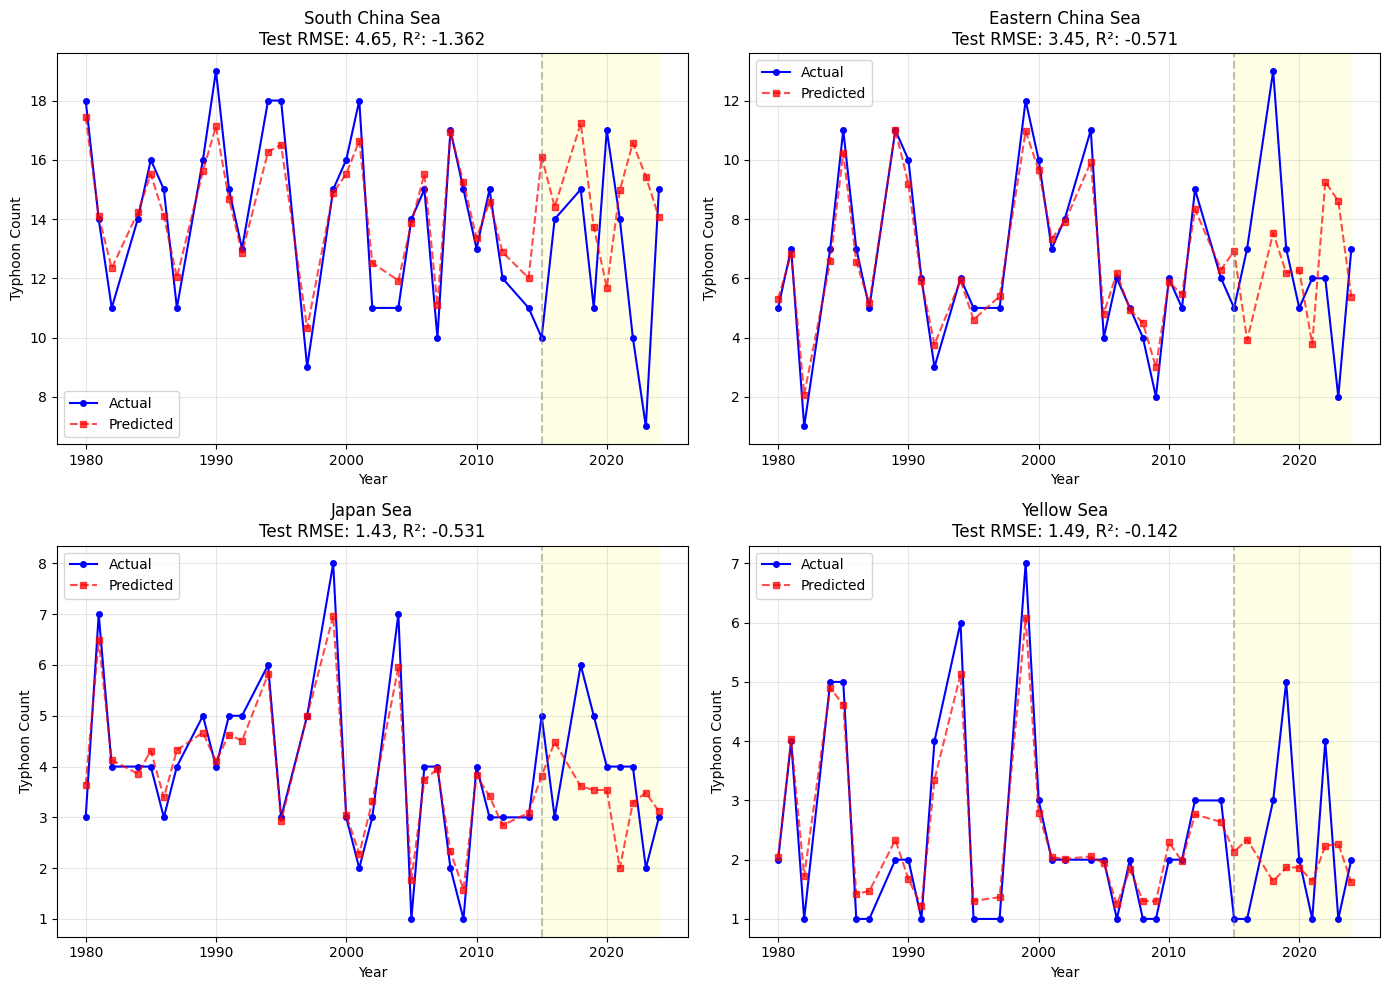

✅ 图表已保存！


In [15]:
# 绘制预测vs实际对比图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (region, result) in enumerate(model.training_history.items()):
    if idx >= 4:
        break
    ax = axes[idx]

    all_years = np.concatenate([result['years_train'], result['years_test']])
    all_actual = np.concatenate([result['y_train'], result['y_test']])
    all_pred = np.concatenate([result['y_train_pred'], result['y_test_pred']])

    ax.plot(all_years, all_actual, 'b-o', label='Actual', markersize=4)
    ax.plot(all_years, all_pred, 'r--s', label='Predicted', markersize=4, alpha=0.7)

    ax.axvline(x=Config.TEST_SPLIT_YEAR, color='gray', linestyle='--', alpha=0.5)
    ax.axvspan(Config.TEST_SPLIT_YEAR, all_years.max(), alpha=0.1, color='yellow')

    ax.set_title(f'{region}\nTest RMSE: {result["test_rmse"]:.2f}, R²: {result["test_r2"]:.3f}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Typhoon Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/prediction_vs_actual.png', dpi=150)
plt.show()
print("✅ 图表已保存！")

In [ ]:
# 绘制特征重要性图
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple']

for idx, (region, importance) in enumerate(model.feature_importance.items()):
    if idx >= 4:
        break
    ax = axes[idx]

    sorted_imp = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))
    ax.barh(list(sorted_imp.keys()), list(sorted_imp.values()), color=colors[idx])
    ax.set_xlabel('Importance')
    ax.set_title(region)
    ax.invert_yaxis()

plt.suptitle('Feature Importance by Region', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/feature_importance.png', dpi=150)
plt.show()